# PH7013 Project

In this project, we want to simulate superconducting qubits to find the optimal control parameters to perform quantum gates.

<figure>
<img src="QHO.png" style="width:75%">
</figure>

Circuit diagram of a superconducting LC circuit and a superconducting qubit and their energy potentials. <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)


Superconducting qubits are derived from superconducting LC circuits, which are quantum harmonic oscillators, by replacing the inductor with a Josephon junction to form an anharmonic oscillator. The lowest two energy levels are then used as the basis states of the qubit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from tqdm import tqdm
from scipy.optimize import curve_fit

In [2]:
# Pauli operator definitions
identity = np.matrix([
    [1, 0],
    [0, 1]
])

sigmaX = np.matrix([
    [0, 1],
    [1, 0]
])

sigmaY = np.matrix([
    [0, -1j],
    [1j, 0]
])

sigmaZ = np.matrix([
    [1, 0],
    [0, -1]
])

# Qubit state definitions
groundState = np.matrix([
    [1],
    [0]
])

excitedState = np.matrix([
    [0],
    [1]
])

In [3]:
def matrixTensordot(array1,array2):
    a=np.tensordot(array1,array2,axes=0)
    b=np.concatenate((a[0][0],a[0][1].T), axis=1)
    c=np.concatenate((a[1][0],a[1][1].T), axis=1)
    return np.concatenate((b,c),axis=0)  

In [4]:
def vectorTensordot(array1, array2):
    a = np.tensordot(array1,array2,axes=0)
    b = np.concatenate((a[0],a[1]), axis=1)
    return np.asmatrix(b).T

In [5]:
normalized_2qubit_state = lambda a,b,c,d : np.array([[a],[b],[c],[d]])/np.linalg.norm(np.array([[a],[b],[c],[d]]))
normalized_1qubit_state = lambda a,b : np.array([[a],[b]])/np.linalg.norm(np.array([[a],[b]]))

In [6]:
psi_1 = normalized_2qubit_state(1,2,3,4)
single_qubit_state_1 = normalized_1qubit_state(1,2)
psi_2 = vectorTensordot(single_qubit_state_1,groundState)

In [7]:
plusZ = groundState
minusZ = excitedState

MZ = lambda psi: np.linalg.norm(plusZ.H * psi)**2 - np.linalg.norm(minusZ.H * psi)**2

plusX = (groundState + excitedState) / np.sqrt(2)
minusX = (groundState - excitedState) / np.sqrt(2)

MX = lambda psi: np.linalg.norm(plusX.H * psi)**2 - np.linalg.norm(minusX.H * psi)**2

plusY = (groundState + 1j * excitedState) / np.sqrt(2)
minusY = (groundState - 1j * excitedState) / np.sqrt(2)

MY = lambda psi: np.linalg.norm(plusY.H * psi)**2 - np.linalg.norm(minusY.H * psi)**2

In [8]:
RX = lambda theta: np.matrix([
    [np.cos(theta / 2),        -1j * np.sin(theta/2)],
    [-1j * np.sin(theta / 2),  np.cos(theta / 2)]
])

RY = lambda theta: np.matrix([
    [np.cos(theta / 2), -np.sin(theta / 2)],
    [np.sin(theta / 2), np.cos(theta / 2)]
])

## Superconducting Qubit XY Control

We use a voltage source to create microwave pulses to drive the qubit between |0> and |1>, the ground and excited states resperctively of the qubit.

From <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1), the driving Hamiltonian of a superconducting qubit can be approximated as

\begin{equation}
    \mathcal{H} = \Omega V_0 s(t) ( \cos{(\phi}) \sigma_x + \sin{(\phi)} \sigma_y )
\end{equation}

under the assumption that the qubit is driven at its resonant frequency, where $\Omega$ is the Rabi frequency of the qubit, $V_0$ is the amplitude of the pulse, $s(t)$ is the time-dependent shape of the pulse, $\phi$ is the phase of the pulse and $\sigma_x, \sigma_y$ are the Pauli matrices.

From Schrödinger's equation, we have

\begin{equation}
    i\hbar \frac{d\psi(t)}{dt} = \mathcal{H}\psi(t)
\end{equation}

As an example, we will apply the adaptive Runge-Kutta (RK4) method to simulate this drive on the ground state of the qubit.

In [9]:
def rungeKutta4StepperError(operator, initCond, time, dt):
    ''' 
    Performs a step composed of 2 RK4 steps an ODE of type dy(t)/dt = f(t,y(t))
    Then performs a single step of RK4 and uses the different solutions to estimate the error
    
    Parameters
        ----------
        operator : function
            function of time (: float) and the y (: float / numpy.array)
            NOTICE: it must a function of both variables even if not explicitly dependence on both
            For instance:   lambda t, y: np.sin(y)    and not     lambda y: np.sin(y) 
        initCond : float / numpy.array
            initial condition, i.e. y(t = initial time)
        initTime : float
            initial time
        dt       : float
            delta t of the step (notice that each substep will act at dt/2)
        
    Returns
        ----------
        solution : numpy.array
            numpy array of the calculated y at the end of the step
        error    : float
            estimation of the error
    '''

    # Performs a RK step for the first half step  (t0 , dt/2)
    k1A = operator(time, initCond)
    k2A = operator(time + dt/4, initCond + dt * k1A/4 )
    k3A = operator(time + dt/4, initCond + dt * k2A/4 )
    k4A = operator(time + dt/2, initCond + dt * k3A/2)
    
    yhalf = initCond + dt * (k1A + 2*k2A + 2*k3A + k4A)/12
    
    # Performs a RK step for the second half step (t0 + dt/2 , dt/2)
    k1B = operator(time + dt/2, yhalf)
    k2B = operator(time + 3*dt/4, yhalf + dt * k1B/4 )
    k3B = operator(time + 3*dt/4, yhalf + dt * k2B/4 )
    k4B = operator(time + dt, yhalf + dt * k3B/2)
    
    ydoublestep = yhalf + dt * (k1B + 2*k2B + 2*k3B + k4B)/12
    
    # Performs RK4 again but by taking a single large step 
    # Does not recalculate the first k, since it it the same as in the 
    # previous case (t0 , dt)
    k2 = operator(time + dt/2, initCond + dt * k1A/2 )
    k3 = operator(time + dt/2, initCond + dt * k2/2 )
    k4 = operator(time + dt, initCond + dt * k3)
    
    ysinglestep = initCond + dt * (k1A + 2*k2 + 2*k3 + k4)/6 
    
    # calculates the error using the function norm to allow for the use with vectors
    error = np.linalg.norm(ydoublestep-ysinglestep)/16
    
    return ydoublestep, error

In [10]:
def rungeKutta4Adaptive(operator, initCond, initTime, finalTime, tolerance):
    ''' 
    Performs a RK4 time stepping of an ODE of type dy(t)/dt = f(t,y(t))
    The time steps are not chosen by the user, but adaptively decided by
    comparing the provided tolerance to the error estimation calculated 
    with the double step method
    
    Parameters
        ----------
        operator    : function
            function of time (: float) and the y (: float / numpy.array)
            NOTICE: it must a function of both variables even if not explicitly dependence on both
            For instance:   lambda t, y: np.sin(y)    and not     lambda y: np.sin(y) 
        initCond    : float / numpy.array
            initial condition, i.e. y(t = initial time)
        initTime    : float
            initial time
        finalTime   : float
            final time of the simulation
            
    Returns
        ----------
        times : numpy.array
            numpy array of the calculated times
        solution    : float
            numpy array of the calculated y's 
    '''
    
    maxIncrementOfdt = 3
    tolerance = abs(tolerance)
    
    # As a first choise of delta t we choose the whole interval
    # We might be lucky and we might be able to calculate directly the 
    # final solution with sufficient precision
    dt = finalTime - initTime
    reachedEnd = False
    times = [initTime]
    solution = [initCond]
    
    while (not(reachedEnd)):
        newy, error = rungeKutta4StepperError(operator, solution[-1], times[-1], dt)
        if (error <= tolerance):
            times.append(times[-1]+dt)
            solution.append(newy)
            dt = dt * (tolerance / error)**(0.25)
            if (times[-1]+dt >= finalTime): 
                dt = min(dt, finalTime-times[-1])
                reachedEnd = True
        else : 
            dt = dt * (tolerance / error)**(0.25)
        
    return np.array(times), np.array(solution)

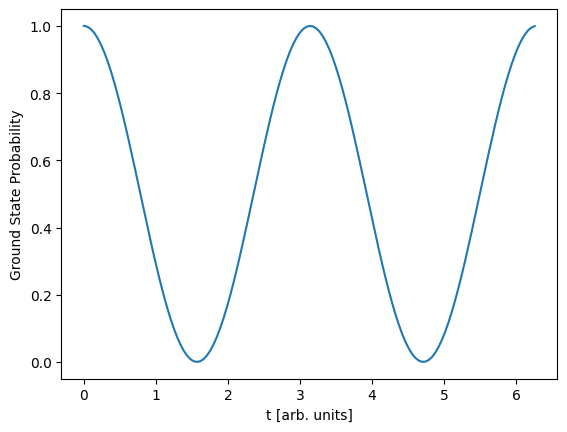

In [11]:
hbar = 1
omega = 1
V = 1
phi = 0 # Assume the phase of the drive to be on resonant with the qubit.

# Here, we use a rectangular pulse envelope where s(t) = 1.
H = omega * V * (np.cos(phi) * sigmaX + np.sin(phi) * sigmaY)

operator = lambda t, y: H/(1j * hbar) * y
t, psi = rungeKutta4Adaptive(
    operator=operator,
    initCond=groundState,
    initTime=0,
    finalTime=2 * np.pi,
    tolerance=1e-10)

# From the qubit state, we extract the ground state probabiltiy at each time step by projecting psi to the ground state.
gndProb = [np.linalg.norm(groundState.H * mat)**2 for mat in psi]

plt.plot(t, gndProb)
plt.xlabel("t [arb. units]")
plt.ylabel("Ground State Probability")
plt.show()

## Simulating the actual XY driving

We can see the rotation of the qubit between $|0>$ and $|1>$ as a function of time. However, in reality, the minimum time step that we can resolve the driving of the qubit is limited by the capability of the instrument. Hence, we will use the normal RK4 time method without adaptive time stepping.


The instrument we use in the lab is the IcarusQ RFSoC <a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2) with a sampling rate of $5898.24$MS/s. For the qubit, we also use a typical Rabi frequency of $20$MHz.

In [12]:
def rungeKutta4(operator, initCond, initTime, finalTime, nSteps):
    ''' 
    Solves an ODE of type dy(t)/dt = f(t,y(t)) using Runge Kutta 4
    
    Parameters
        ----------
        operator  : function
            function of time (: float) and the y (: float / numpy.array)
            NOTICE: it must a function of both variables even if not explicitly dependent on both
            For instance:   lambda t, y: np.sin(y)    and not     lambda y: np.sin(y) 
        initCond  : float / numpy.array
            initial condition, i.e. y(t = initial time)
        initTime  : float
            initial time
        finalTime : float
            final time of the simulation
        nSteps    : int
            number of steps to take
        
    Returns
        ----------
        times : numpy.array
            numpy array of all the calculated times
        solution : numpy.array
            numpy array of all the calculated y's
    '''
    
    dt = (finalTime - initTime)/nSteps
    times = np.linspace(initTime, finalTime, nSteps+1)
    solut = [initCond]
    for t in times[:-1]:
        k1 = dt * operator(t, solut[-1])
        k2 = dt * operator(t + dt/2, solut[-1] + k1/2 )
        k3 = dt * operator(t + dt/2, solut[-1] + k2/2 )
        k4 = dt * operator(t + dt, solut[-1] + k3)
        solut.append(solut[-1] + (k1 + 2*k2 + 2*k3 + k4)/6 )
        
    return times, np.array(solut)

In [13]:
def rungeKutta4_updated(operator, initCond, initTime, finalTime, nSteps):
    ''' 
    Solves an ODE of type dy(t)/dt = f(t,y(t)) using Runge Kutta 4
    
    Parameters
        ----------
        operator  : function
            function of time (: float) and the y (: float / numpy.array)
            NOTICE: it must a function of both variables even if not explicitly dependent on both
            For instance:   lambda t, y: np.sin(y)    and not     lambda y: np.sin(y) 
        initCond  : float / numpy.array
            initial condition, i.e. y(t = initial time)
        initTime  : float
            initial time
        finalTime : float
            final time of the simulation
        nSteps    : int
            number of steps to take
        
    Returns
        ----------
        times : numpy.array
            numpy array of all the calculated times
        solution : numpy.array
            numpy array of all the calculated y's
    '''
    
    dt = (finalTime - initTime)/nSteps
    times = np.linspace(initTime, finalTime, nSteps+1)
    solut = [initCond]
    for t in times[:-1]:
        k0 = operator(t,solut[-1])
        if k0.shape != (4,1):
            print('oh no')
            break
        k1 = dt * operator(t, solut[-1])
        k2 = dt * operator(t + dt/2, solut[-1] + k1/2 )
        k3 = dt * operator(t + dt/2, solut[-1] + k2/2 )
        k4 = dt * operator(t + dt, solut[-1] + k3)
        solut.append(solut[-1] + (k1 + 2*k2 + 2*k3 + k4)/6 )
        
    return times, np.array(solut,dtype=object)

We want to also investigate any potential impact of our instrument on the simulation. While driving microwave pulses at the qubit frequency, our instrument has a phase standard deviation of about $0.382$ degrees and an amplitude standard deviation that is about $0.01$. This is simulated from a normal distribution.

Both the phase and amplitude uncertainty of the instrument reduce the Rabi frequency, but in our case, it seems to be minimal. However, as seen in the driving Hamiltonian, the phase will also influence the axis of the rotation about the Bloch sphere.

In quantum computing, we are also concerned with the fidelity of the rotation. Hence, it may make more sense to measure the expectation values of the $x, y, z$ measurement operators.

From this, we now have a good model of how to compute the fidelity of the pulse and formulate a loss function for a gate. Next, we want to introduce the frequency drift component and pulse shaping to lower the pulse frequency bandwidth. A more complete qubit driving Hamiltonian that takes into account the detuning bet is as follows

\begin{equation}
    \mathcal{H} = \Omega V_0 s(t) ( (-I\cos{(\delta \omega t)} + Q\sin{(\delta \omega t)})\sigma_x + (I\sin{(\delta \omega t)}-Q\cos{(\delta \omega t)})\sigma_y)
\end{equation}

where $I = \cos{\phi}$, $Q=\sin{\phi}$ and $\delta \omega$ is the frequency detuning between the pulse frequency and the qubit frequency.

To get the frequency deviation of the qubit, we perform a Ramsey experiment on one of our qubits over 14 hours. A Ramsey experiment is when two $\pi$/2-pulses are sent to the qubit and a delay $\tau$ between the pulses is varied. The frequency of the Ramsey oscillation yields the frequency detuning between the driving frequency and the actual qubit frequency.

<figure>
<img src="14h_ramsey.png" style="width:100%">
</figure>

Ramsey fringes over 14 hours performed on the IQM chip, qubit 1.

<figure>
<img src="ramsey_drift.png" style="width:100%">
</figure>

Ramsey frequency extracted from the Ramsey fringes over 14 hours for IQM chip, qubit 1.

The standard deviation of the frequency for this qubit is $52.769$MHz.

To decrease the frequency bandwidth of the driving pulse and avoid state leakage, we use a cosine-sum signal Hamming window, given by the following equation.

\begin{equation}
    s(t) = a_0 - (1 - a_0)\cos{(\frac{2\pi t}{T})}
\end{equation}

where $a_0 = 25/46$ for the Hamming window and $T$ is the length of the pulse.

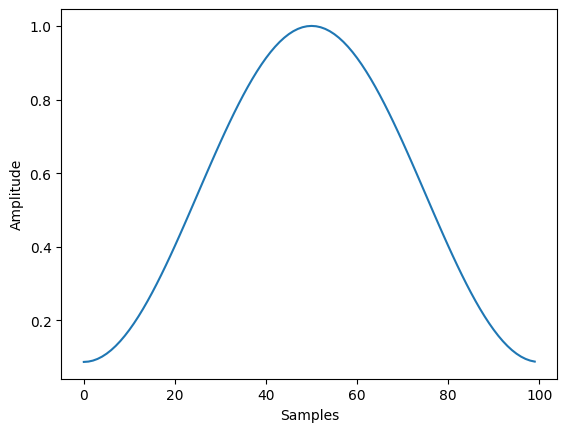

In [14]:
aNaught = 25 / 46
N = 100
hammingEnvelopeTrial = aNaught - (1 - aNaught) * np.cos(2 * np.pi * np.arange(N) / N)

plt.plot(hammingEnvelopeTrial)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

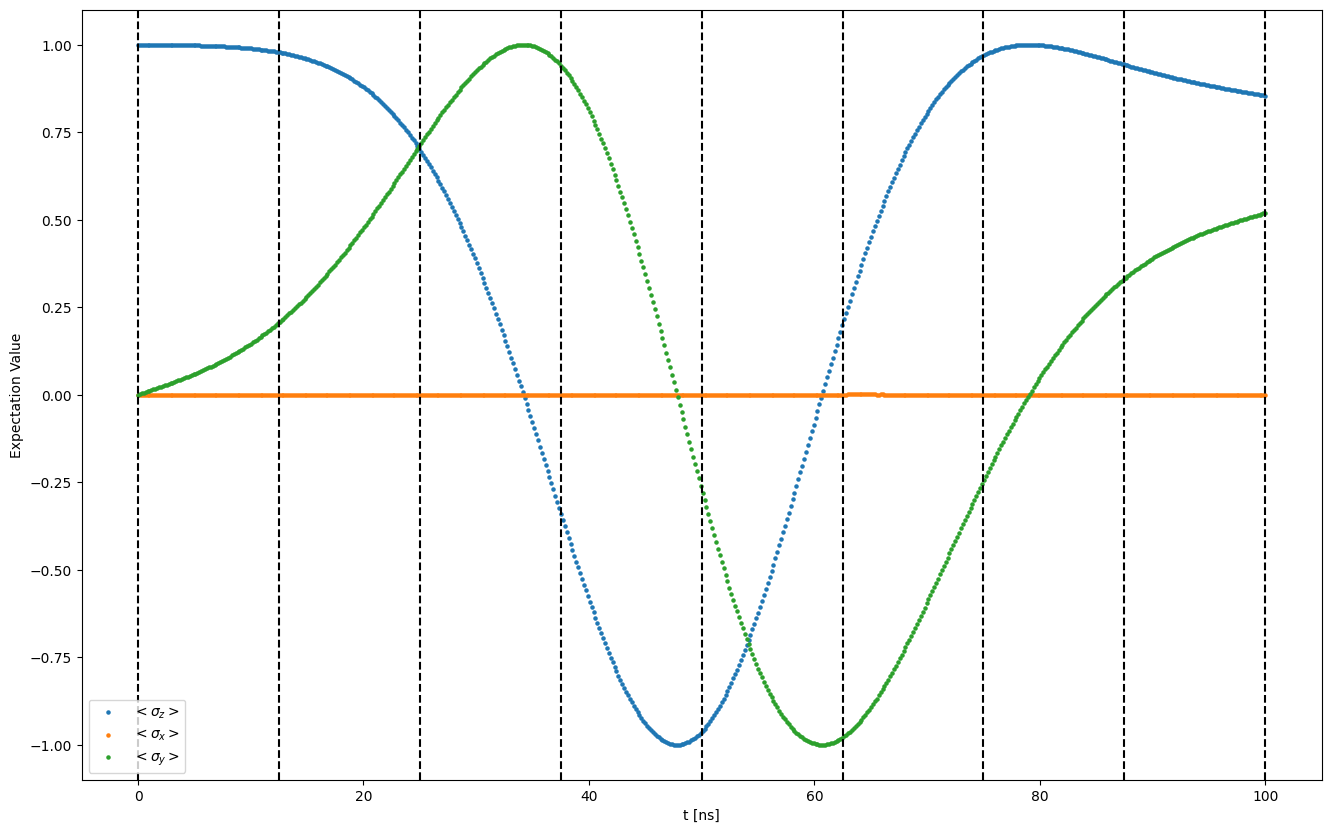

In [15]:
initTime = 0
finalTime = 100e-9 # 100ns
samplingRate = 5898.24e6 # 5.89824 GS/s
nSteps = int(samplingRate * (finalTime - initTime))

VStd = 0.01
phaseStd = 0.382 / 180 * np.pi
detuningStd = 52769

omega = 20e6 # 20MHz
VNaught = 1
hbar = 1
phiNaught = 0
aNaught = 25 / 46


def operator(t, y):
    V = VNaught + np.random.normal(scale=VStd)
    phi = phiNaught + np.random.normal(scale=phaseStd)
    I = np.cos(phi)
    Q = np.sin(phi)
    
    dwt = np.random.normal(scale=detuningStd) * t
    s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / finalTime)
    H = omega * np.pi * V * s * ((-I * np.cos(dwt) + Q * np.sin(dwt)) * sigmaX + (I * np.sin(dwt) - Q * np.cos(dwt)) * sigmaY)
    return H/(1j* hbar) * y


t, psiArray = rungeKutta4(operator, groundState, initTime, finalTime, nSteps)
expectZ = [MZ(psi) for psi in psiArray]
expectX = [MX(psi) for psi in psiArray]
expectY = [MY(psi) for psi in psiArray]

plt.figure(figsize=(16, 10))
plt.scatter(t / 1e-9, expectZ, s=5, label=r"$<\sigma_z>$")
plt.scatter(t / 1e-9, expectX, s=5, label=r"$<\sigma_x>$")
plt.scatter(t / 1e-9, expectY, s=5, label=r"$<\sigma_y>$")

for x in [0, 12.5, 25, 37.5, 50, 62.5, 75, 87.5, 100]:
    plt.axvline(x, linestyle='dashed', color='k')
    
plt.legend()
plt.xlabel("t [ns]")
plt.ylabel("Expectation Value")
plt.show()

Next, for quantum gates, we need the pulse time $t$ required to flip the qubit between $|0>$ and $|1>$. This pulse is known as the $\pi$-pulse. For this, we can use the interpolation function to search when we reach the $-1$ eigenvalue of $\sigma_z$.

In [16]:
def optimiseInterpol(funcToUse, xleft, xright, maxNumberIteration, 
                   positionToleranceAbsolute, valueToleranceAbsolute = 0.):
    """ Finds the maximum or minimum by using quadratic interpolation  """    
    
    
    
    # Notice how the function does not require the user to provide the third point
    # The third point is constructed as the middle of the interval.
    # You do not need to implement your code in this way.
    # I did it because it reduces the number of parameters the final user has to pass
    # to the function, without really affecting what the algorithm does.
    
    # Construct the array of points at which to evaluate the function (notice how the second point is built)
    xs = np.array([xleft,(xleft+xright)/2,xright])   
    
    # evaluates the function at the current points
    fs = [funcToUse(x) for x in xs]
    
    # We implement the second method to estimate the error
    # However that method requires an old value. 
    # What happens at the first iteration? There is no old value. 
    # To prevent the program from breaking, we assign values to these two variables
    # as if they are our very first guess of the position and value of the minimum
    xmin = (xleft+xright)/2
    fmin = fs[1]
    
    # We do not want the while loop to stop immediately, so we give an intitial value to our errors 
    # that will ensure that the loop is executed the first time
    positionError  = 10 * abs(positionToleranceAbsolute) + 1
    valueError     = 10 * abs(valueToleranceAbsolute) + 1

    # As we want to keep track of the number of iterations done, we initialise the counter to 0
    iteration = 0
    
    
    while (positionError > positionToleranceAbsolute and valueError > valueToleranceAbsolute) \
        and iteration < maxNumberIteration:
        
        # Increment the counter of number of iterations
        iteration += 1
        
        # Since xmin and fmin are going to be overwritten by the new guess, we store the current value
        oldx = xmin
        oldf = fmin
        
        
        # finds the position of the next guess at the position of the minimum and overwrites the old guess
        xmin    = - 0.5 * (xs[2]**2 * (fs[0] - fs[1]) + xs[1]**2 * (fs[2] - fs[0]) + 
                   xs[0]**2 * (fs[1] - fs[2])) / (xs[2] * (fs[1] - fs[0]) + xs[1] 
                * (fs[0] - fs[2]) + xs[0] * (fs[2] - fs[1]))
        fmin    = funcToUse(xmin)
        
        # Calculates the improvement in position and value compared to previous iteration
        # to be compared with tolerance
        positionError = abs(xmin-oldx)
        valueError    = abs(fmin-oldf)
        
        # Now we need to discard one of the old three points
        
        # finds the furthest point to discard
        distances = abs(xs-xmin)              # calculates the distance of the old points from new one
        indexFurthest = np.argmax(distances)  # find which is the furthest
        xs[indexFurthest] = xmin       # substitutes the furthest with the new one
        fs[indexFurthest] = fmin       # substitutes the value of f on the furthest with the value on the new one
        
    return xmin, fmin, iteration

Next, we define the objective function.

In [17]:
initTime = 0
finalTime = 100e-9 # 100ns
samplingRate = 5898.24e6 # 5.89824 GS/s

VStd = 0.01
phaseStd = np.sqrt(2) / 180 * np.pi
detuningStd = 52769

omega = 20e6 # 20MHz
VNaught = 1
hbar = 1
phiNaught = 0
aNaught = 25 / 46

def measureFidelityForPiRotation(finalTime):
    """Returns the expectation value of the sigma Z operator (plus 1 for minimization) for a given duration of time evolution.
    
    Arguments:
        finalTime (float): Duration of the time evolution.
        
    Returns:
        expectationValue (float): Expectation value of sigma Z.
    """
    nSteps = int(samplingRate * finalTime)
    
    def operator(t, y):
        V = VNaught + np.random.normal(scale=VStd)
        phi = phiNaught + np.random.normal(scale=phaseStd)
        I = np.cos(phi)
        Q = np.sin(phi)

        dwt = np.random.normal(scale=detuningStd) * t
        s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / finalTime)
        H = omega * np.pi * V * s * ((-I * np.cos(dwt) + Q * np.sin(dwt)) * sigmaX + (I * np.sin(dwt) - Q * np.cos(dwt)) * sigmaY)
        return H/(1j* hbar) * y
    
    t, psi = rungeKutta4(operator, groundState, initTime, finalTime, nSteps)
    expectZ = MZ(psi[-1])
    
    return expectZ + 1

Pi-pulse Time: 45.99ns


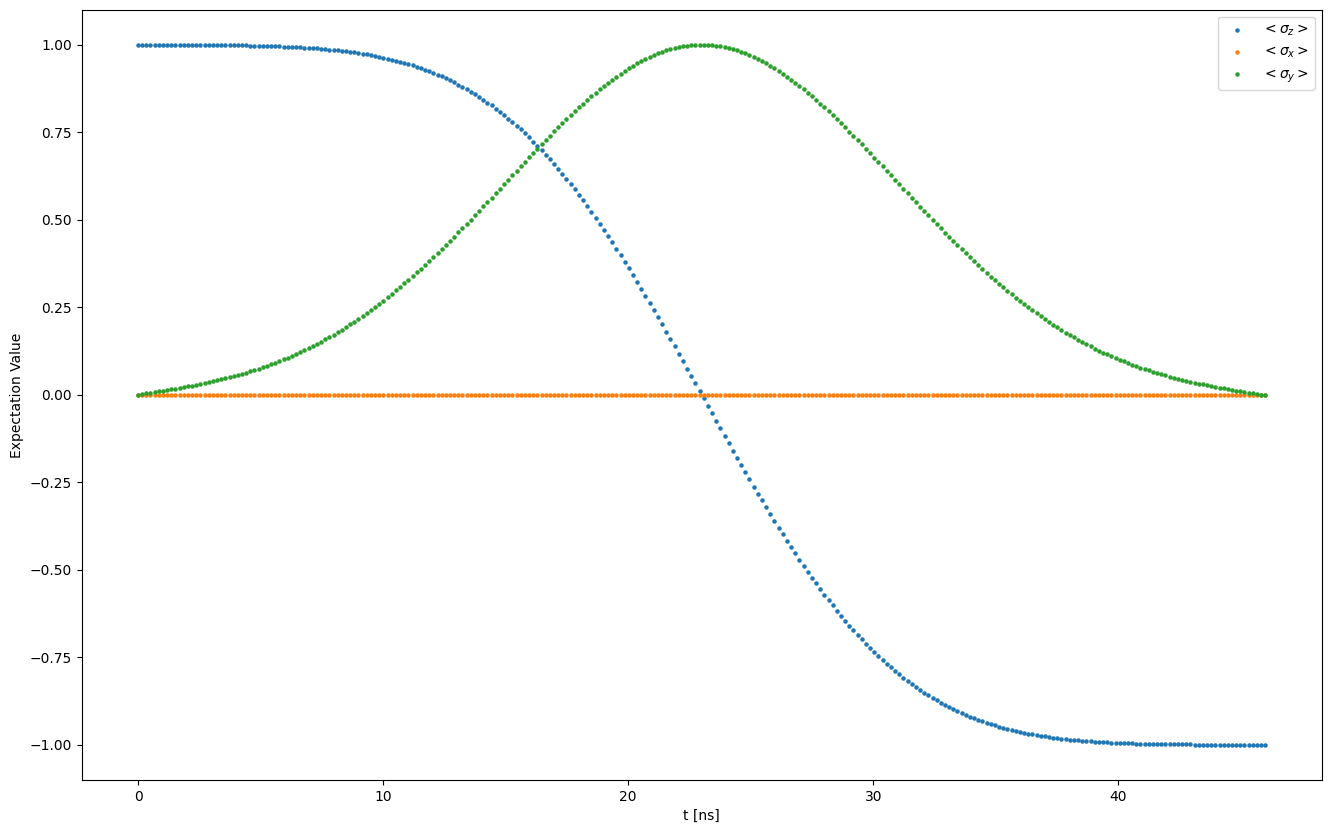

In [18]:
piPulseDuration, fmin, iteration = optimiseInterpol(measureFidelityForPiRotation, 5e-9, 80e-9, 100, 1/5898.24e6)
initTime = 0
finalTime = piPulseDuration
samplingRate = 5898.24e6 # 5.89824 GS/s
nSteps = int(samplingRate * (finalTime - initTime))

VStd = 0.01
phaseStd = 0.382 / 180 * np.pi
detuningStd = 52769

omega = 20e6 # 20MHz
VNaught = 1
hbar = 1
phiNaught = 0
aNaught = 25 / 46


def operator(t, y):
    V = VNaught + np.random.normal(scale=VStd)
    phi = phiNaught + np.random.normal(scale=phaseStd)
    I = np.cos(phi)
    Q = np.sin(phi)
    dwt = np.random.normal(scale=detuningStd) * t
    s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / finalTime)
    H = omega * np.pi * V * s * ((-I * np.cos(dwt) + Q * np.sin(dwt)) * sigmaX + (I * np.sin(dwt) - Q * np.cos(dwt)) * sigmaY)
    return H/(1j* hbar) * y


t, psiArray = rungeKutta4(operator, groundState, initTime, finalTime, nSteps)
expectZ = [MZ(psi) for psi in psiArray]
expectX = [MX(psi) for psi in psiArray]
expectY = [MY(psi) for psi in psiArray]

plt.figure(figsize=(16, 10))
plt.scatter(t / 1e-9, expectZ, s=5, label=r"$<\sigma_z>$")
plt.scatter(t / 1e-9, expectX, s=5, label=r"$<\sigma_x>$")
plt.scatter(t / 1e-9, expectY, s=5, label=r"$<\sigma_y>$")
    
plt.legend()

print(f"Pi-pulse Time: {int(piPulseDuration * 1e11) / 1e2}ns")
plt.xlabel("t [ns]")
plt.ylabel("Expectation Value")
plt.show()

We perform a similar treatment to above to find the pulse duration for a $\pi/2$-pulse.

In [19]:
initTime = 0
samplingRate = 5898.24e6 # 5.89824 GS/s

VStd = 0.01
phaseStd = np.sqrt(2) / 180 * np.pi
detuningStd = 52769

omega = 20e6 # 20MHz
VNaught = 1
hbar = 1
phiNaught = 0
aNaught = 25 / 46

def measureFidelityForPiHalfRotation(finalTime):
    """Returns the expectation value of the sigma Z operator for a given duration of time evolution.
    
    Arguments:
        finalTime (float): Duration of the time evolution.
        
    Returns:
        expectationValue (float): Expectation value of sigma Z.
    """
    nSteps = int(samplingRate * finalTime)
    
    def operator(t, y):
        V = VNaught + np.random.normal(scale=VStd)
        phi = phiNaught + np.random.normal(scale=phaseStd)
        I = np.cos(phi)
        Q = np.sin(phi)
        dwt = np.random.normal(scale=detuningStd) * t
        s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / finalTime)
        H = omega * np.pi * V * s * ((-I * np.cos(dwt) + Q * np.sin(dwt)) * sigmaX + (I * np.sin(dwt) - Q * np.cos(dwt)) * sigmaY)
        return H/(1j* hbar) * y
    
    t, psi = rungeKutta4(operator, groundState, initTime, finalTime, nSteps)
    expectZ = np.abs(MZ(psi[-1]))
    
    return expectZ

Pi/2-pulse Time: 23.04ns


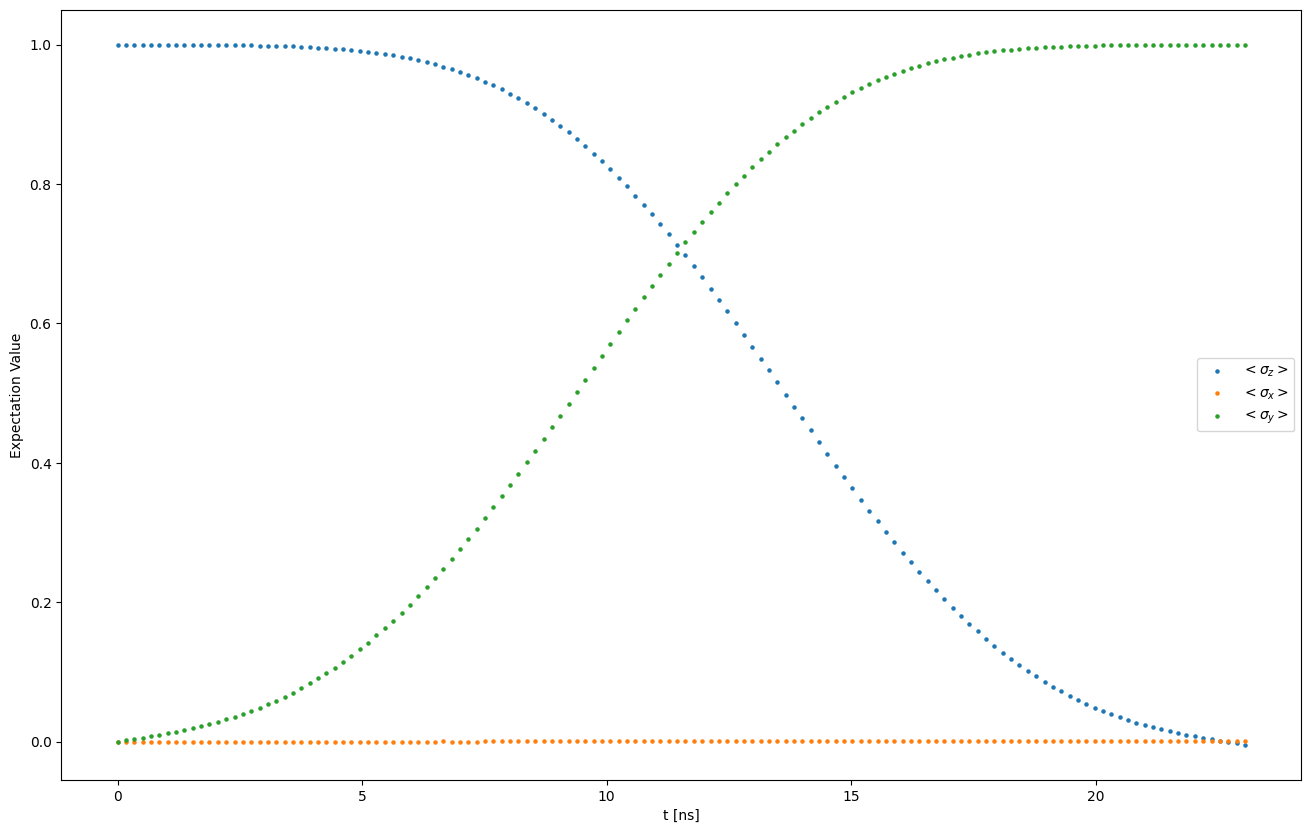

In [20]:
piHalfPulseDuration, fmin, iteration = optimiseInterpol(measureFidelityForPiHalfRotation, 5e-9, 50e-9, 100, 1/5898.24e6)
initTime = 0
finalTime = piHalfPulseDuration
samplingRate = 5898.24e6 # 5.89824 GS/s
nSteps = int(samplingRate * (finalTime - initTime))

VStd = 0.01
phaseStd = 0.382 / 180 * np.pi
detuningStd = 52769

omega = 20e6 # 20MHz
VNaught = 1
hbar = 1
phiNaught = 0
aNaught = 25 / 46


def operator(t, y):
    V = VNaught + np.random.normal(scale=VStd)
    phi = phiNaught + np.random.normal(scale=phaseStd)
    I = np.cos(phi)
    Q = np.sin(phi)
    dwt = np.random.normal(scale=detuningStd) * t
    s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / finalTime)
    H = omega * np.pi * V * s * ((-I * np.cos(dwt) + Q * np.sin(dwt)) * sigmaX + (I * np.sin(dwt) - Q * np.cos(dwt)) * sigmaY)
    return H/(1j* hbar) * y


t, psiArray = rungeKutta4(operator, groundState, initTime, finalTime, nSteps)
expectZ = [MZ(psi) for psi in psiArray]
expectX = [MX(psi) for psi in psiArray]
expectY = [MY(psi) for psi in psiArray]

plt.figure(figsize=(16, 10))
plt.scatter(t / 1e-9, expectZ, s=5, label=r"$<\sigma_z>$")
plt.scatter(t / 1e-9, expectX, s=5, label=r"$<\sigma_x>$")
plt.scatter(t / 1e-9, expectY, s=5, label=r"$<\sigma_y>$")
    
plt.legend()

print(f"Pi/2-pulse Time: {int(piHalfPulseDuration * 1e11) / 1e2}ns")
plt.xlabel("t [ns]")
plt.ylabel("Expectation Value")
plt.show()

## Randomized Benchmarking (RB)

To gauge the fidelity of the XY control, we use the RB scheme, where we perform gates at random and measure the accumulation of gate errors. This yields the average fidelity of the qubit gateset.

Typically, we select a gate at random from the Clifford group, apply it on the qubit and repeat this procedure $N$ times. At the end of the sequence of $N$ Cliffords, we apply an inverse gate to return it to the ground state. Finally, we measure the ground state population. For this project, we will be using the single qubit Clifford group $C_1$. This single qubit gate group can be composed with just $X$ and $Y$ rotations.

In [21]:
samplingRate = 5898.24e6 # 5.89824 GS/s

VStd = 0.01
phaseStd = np.sqrt(2) / 180 * np.pi
detuningStd = 52769

omega = 20e6 # 20MHz
VNaught = 1
hbar = 1
phiNaught = 0
aNaught = 25 / 46

# We define an envelope function conditioned on the final size of the window (finalTime) and the current step (t)
hamming = lambda finalTime: lambda t: aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / finalTime)

In [22]:
class SimulationPulse:
    """Describes a pulse Hamiltonian to be simulated
    
    Arguments:
        pulseTIme (float): Duration of the pulse.
        envelopeFunction (callable -> callable): @see this cell for an example of an envelope function
        phi (float): Phase of the pulse.
    """
    def __init__(self, pulseTime, phi=0, envelopeFunction=hamming):
        self.phi = phi
        self.pulseTime = pulseTime
        self.envelope = envelopeFunction(pulseTime)
        self.nsteps = int(samplingRate * pulseTime)

    def simulate(self, initialState):
        """Simulates the evolution of a given initial state.
        
        Arguments:
            initialState (np.matrix): Initial state to simulate
            
        Returns:
            finalState (np.matrix): Final simulated state after evolution
        """
        _, psiArray = rungeKutta4(self.operator, initialState, 0, self.pulseTime, self.nsteps)
        return psiArray[-1]
    
    def operator(self, t, y):
        """Derivative operator.
        
        Arguments:
            t (float): Time step.
            y (np.matrix): Current state of the system at time t.
        """
        
        V = VNaught + np.random.normal(scale=VStd)
        phi = self.phi + np.random.normal(scale=phaseStd)
        dwt = np.random.normal(scale=detuningStd) * t

        I = np.cos(phi)
        Q = np.sin(phi)
        s = self.envelope(t)

        H = omega * np.pi * V * s * ((-I * np.cos(dwt) + Q * np.sin(dwt)) * sigmaX + (I * np.sin(dwt) - Q * np.cos(dwt)) * sigmaY)
        return H/(1j* hbar) * y

In [23]:
IGate = RX(0)

XPulse = SimulationPulse(piPulseDuration)
YPulse = SimulationPulse(piPulseDuration, phi=np.pi / 2)
XHalfPulse = SimulationPulse(piHalfPulseDuration)
YHalfPulse = SimulationPulse(piHalfPulseDuration, phi=np.pi / 2)
XHalfMinusPulse = SimulationPulse(piHalfPulseDuration, phi=-np.pi)
YHalfMinusPulse = SimulationPulse(piHalfPulseDuration, phi=-np.pi / 2)

In [24]:
matrices = [

        IGate,
        RX(np.pi), # X
        RY(np.pi), # Y,
        RY(np.pi) * RX(np.pi), # Z
        
        RX(np.pi / 2), # X/2
        RX(-np.pi / 2), # -X/2
        RY(np.pi / 2), # Y/2
        RY(-np.pi / 2), # -Y/2
        RX(-np.pi / 2) * RY(np.pi / 2) * RX(np.pi / 2),
        RX(-np.pi / 2) * RY(-np.pi / 2) * RX(np.pi / 2),
        
        RX(np.pi) * RY(-np.pi / 2), 
        RX(np.pi) * RY(np.pi / 2), 
        RY(np.pi) * RX(np.pi / 2),
        RY(np.pi) * RX(-np.pi / 2),
        RX(np.pi / 2) * RY(np.pi / 2) * RX(np.pi / 2),
        RX(-np.pi / 2) * RY(np.pi / 2) * RX(-np.pi / 2),
        
        RY(np.pi / 2) * RX(np.pi / 2),
        RY(np.pi / 2) * RX(-np.pi / 2),
        RY(-np.pi / 2) * RX(np.pi / 2),
        RY(-np.pi / 2) * RX(-np.pi / 2),
        RX(np.pi / 2) * RY(np.pi / 2),
        RX(np.pi / 2) * RY(-np.pi / 2),
        RX(-np.pi / 2) * RY(np.pi / 2),
        RX(-np.pi / 2) * RY(-np.pi / 2),
    ] 

In [25]:
pulses = [
        [],
        [XPulse],
        [YPulse],
        [XPulse, YPulse],

        [XHalfPulse],
        [XHalfMinusPulse],
        [YHalfPulse],
        [YHalfMinusPulse],
        [XHalfPulse, YHalfPulse, XHalfMinusPulse],
        [XHalfPulse, YHalfMinusPulse, XHalfMinusPulse],

        [YHalfMinusPulse, XPulse],
        [YHalfPulse, XPulse],
        [XHalfPulse, YPulse],
        [XHalfMinusPulse, YPulse],
        [XHalfPulse, YHalfPulse, XHalfPulse],
        [XHalfMinusPulse, YHalfPulse, XHalfMinusPulse],

        [XHalfPulse, YHalfPulse],
        [XHalfMinusPulse, YHalfPulse],
        [XHalfPulse, YHalfMinusPulse],
        [XHalfMinusPulse, YHalfMinusPulse],
        [YHalfPulse, XHalfPulse],
        [YHalfMinusPulse, XHalfPulse],
        [YHalfPulse, XHalfMinusPulse],
        [YHalfMinusPulse, XHalfMinusPulse],
    ]

In [26]:
class SingleQubitCliffordGroup:
    """Handler for operations on the single qubit Clifford group.
    """
    
    # Matrices corresponding to the single qubit Cliffords
    matrices = matrices
    
    # Pulses corresponding to the single qubit Cliffords, these are in reverse order compared to the matrices.
    pulses = pulses
    
    numSingleQubitCliffords = 24
    
    @staticmethod
    def generateCliffordSequence(numGates: int):
        """Generates a sequence of pulse Hamiltonians corresponding to random single qubit Cliffords for a given number of Cliffords.
        
        Arguments:
            numGates (int): Desired length of the Clifford sequence.
            
        Returns:
            pulseSequence (SimulationPulse[]): Array of pulse Hamiltonians.
        """
        
        # First, we create a random sequence of Cliffords
        # This is an array of random indices corresponding to each Clifford element
        sequenceIndices = np.random.choice(SingleQubitCliffordGroup.numSingleQubitCliffords, size=numGates)
        
        # Next, we want to multiply each Clifford together to accumulate the final Cliifford
        finalClifford = reduce(SingleQubitCliffordGroup.cliffordReducer, sequenceIndices, IGate)
        # Then, we want to find the inverse member which returns the system back to its original state.
        inverseCliffordIndex = SingleQubitCliffordGroup.cliffordInverseSearcher(finalClifford)
        
        return reduce(SingleQubitCliffordGroup.pulseReducer, sequenceIndices, []), SingleQubitCliffordGroup.pulses[inverseCliffordIndex], inverseCliffordIndex
        
    @staticmethod
    def cliffordReducer(accumulatedClifford, nextCliffordIndex):
        """Reducer function to multiply an array of Clifford matrices (from their indices) into a final Clifford matrix.
        """
        
        return np.matmul(SingleQubitCliffordGroup.matrices[nextCliffordIndex], accumulatedClifford)
    
    @staticmethod
    def pulseReducer(pulseSequence, nextCliffordIndex):
        """Reducer function to unpack nested arrays of SimulationPulse.
        """
        return pulseSequence + SingleQubitCliffordGroup.pulses[nextCliffordIndex]
    
    
    @staticmethod
    def cliffordInverseSearcher(clifford):
        """Searches for an Clifford gate that returns the system back to the ground state, ignoring accumulated phase.
        
        Arguments:
            clifford (np.matrix): Clifford matrix to be applied to the system
            
        Returns:
            inverseIndex (int): Index of the Clifford that returns the system to the ground state.
        """
        psi = clifford * groundState
        for index, matrix in enumerate(SingleQubitCliffordGroup.matrices):
            if np.allclose(np.abs(matrix * psi), groundState):
                return index
            
        raise RuntimeError("Could not find an inverse Clifford", clifford)

Finally, we can start the RB protocol. Typically, we sweep the value of $N$ in the order of 50 to 100s of pulses. We also repeat the RB protocol for each value of $N$. 

In [27]:
finalN = 100
averaging = 20

nSweep = np.linspace(1, finalN, 25, dtype=int)
# Hold the results in a 2D array corresponding to the number of gates and the repetition
results = np.zeros((nSweep.shape[0], averaging))

RBPulseReducer = lambda psi, pulse: pulse.simulate(psi)
inverse_gate_list = np.ndarray((nSweep.shape[0], averaging),dtype=object)
state_before_ZZ = np.ndarray((nSweep.shape[0], averaging),dtype=object)
inverse_index_list = np.ndarray((nSweep.shape[0], averaging),dtype=object)

for idx, ngates in enumerate(tqdm(nSweep)):
    # Repeat the RB sequence for N gates averaging times to build statistics
    for k in range(averaging):
        initialState = groundState
        cliffordSequence, inverseGate, inverse_clifford_index = SingleQubitCliffordGroup.generateCliffordSequence(ngates)
        finalState = reduce(RBPulseReducer, cliffordSequence, initialState)
        # Project the final state to the ground state and store it in the array
        state_before_ZZ[idx,k] = finalState
        inverse_gate_list[idx,k] = inverseGate
        inverse_index_list[idx,k] = inverse_clifford_index

  0%|          | 0/25 [00:00<?, ?it/s]

 92%|█████████▏| 23/25 [29:05<03:49, 114.90s/it]

In [ ]:
results[idx, k] = np.linalg.norm(groundState.H * finalState)**2

Next, we want to determine the gate fidelity. The ground state fidelity is determined by

\begin{equation}
    y = a + bp^x
\end{equation}

where $y$ is the ground state fidelity, $a, b$ capture the state preperation and measurement errors, $x$ is the number of Cliffords and $p$ captures the decay gradient. The error per clifford (EPC) is given by

\begin{equation}
    \epsilon_C = (1 - p) * 0.5
\end{equation}

As there are $1.875$ physical gates per Clifford, we then retrieve the approximate error per gate (EPG) as
\begin{equation}
    \epsilon_G = \frac{\epsilon_C}{1.875}
\end{equation}

The gate fidelity is then defined as
\begin{equation}
    \mathcal{F} = 1 - \epsilon_G
\end{equation}

As we increase the number of gates, we expect the errors from the phase and amplitude uncertainties to accumulate. However, in this case, we did not include the effect of decoherence on the qubit. To do so, we would have to work with density matrices and unitaries instead.

The Bloch-Redfield density matrix is defined as
\begin{equation}
    \rho_{BR} = \begin{bmatrix} 1 + (|\alpha|^2 -1)e^{-\Gamma_1 t} & \alpha\beta^* e^{i\delta \omega t} e^{-\Gamma_2 t} \\ \alpha^*\beta e^{i\delta \omega t} e^{-\Gamma_2 t} & |\beta|^2e^{-\Gamma_1 t} \end{bmatrix}
\end{equation}
where $\alpha, \beta$ are the probabilitiy amplitudes of the initial state, $\Gamma_1$ describes the longitudinal relaxation or fluorescence and $\Gamma_2$ describes the transverse relaxation. However, this is outside the scope of the project.

In conclusion, we have demonstrated how to simulate superconducting qubit control, include pulse shaping and demonstrated ths control on a RB experiment.

## Two qubit

In [ ]:
identity_tensor_sigmaX = matrixTensordot(identity,sigmaX)
identity_tensor_sigmaY = matrixTensordot(identity,sigmaY)
sigmaZ_tensor_sigmaZ = matrixTensordot(sigmaZ,sigmaZ)
groundState2qubit = vectorTensordot(groundState,groundState)
excitedState2qubit = vectorTensordot(groundState,excitedState)

In [ ]:
RX2qubit = lambda theta: matrixTensordot(identity,np.matrix([
    [np.cos(theta / 2),        -1j * np.sin(theta/2)],
    [-1j * np.sin(theta / 2),  np.cos(theta / 2)]
]))

RY2qubit = lambda theta: matrixTensordot(identity, np.matrix([
    [np.cos(theta / 2), -np.sin(theta / 2)],
    [np.sin(theta / 2), np.cos(theta / 2)]
]))

class SimulationPulse2qubit:
    """Describes a pulse Hamiltonian to be simulated
    
    Arguments:
        pulseTIme (float): Duration of the pulse.
        envelopeFunction (callable -> callable): @see this cell for an example of an envelope function
        phi (float): Phase of the pulse.
    """
    def __init__(self, pulseTime, phi=0, envelopeFunction=hamming):
        self.phi = phi
        self.pulseTime = pulseTime
        self.envelope = envelopeFunction(pulseTime)
        self.nsteps = int(samplingRate * pulseTime)

    def simulate(self, initialState):
        """Simulates the evolution of a given initial state.
        
        Arguments:
            initialState (np.matrix): Initial state to simulate
            
        Returns:
            finalState (np.matrix): Final simulated state after evolution
        """
        _, psiArray = rungeKutta4_updated(self.operator, initialState, 0, self.pulseTime, self.nsteps)
        return psiArray[-1]
    
    def operator(self, t, y):
        """Derivative operator.
        
        Arguments:
            t (float): Time step.
            y (np.matrix): Current state of the system at time t.
        """
        
        V = VNaught + np.random.normal(scale=VStd)
        phi = self.phi + np.random.normal(scale=phaseStd)
        dwt = np.random.normal(scale=detuningStd) * t

        I = np.cos(phi)
        Q = np.sin(phi)
        s = self.envelope(t)

        H = omega * np.pi * V * s * ((-I * np.cos(dwt) + Q * np.sin(dwt)) * identity_tensor_sigmaX + (I * np.sin(dwt) - Q * np.cos(dwt)) * identity_tensor_sigmaX)
        return H/(1j* hbar) * y

In [ ]:
IGate2qubit = RX2qubit(0)

XPulse2qubit = SimulationPulse2qubit(piPulseDuration)
YPulse2qubit = SimulationPulse2qubit(piPulseDuration, phi=np.pi / 2)
XHalfPulse2qubit = SimulationPulse2qubit(piHalfPulseDuration)
YHalfPulse2qubit = SimulationPulse2qubit(piHalfPulseDuration, phi=np.pi / 2)
XHalfMinusPulse2qubit = SimulationPulse2qubit(piHalfPulseDuration, phi=-np.pi)
YHalfMinusPulse2qubit = SimulationPulse2qubit(piHalfPulseDuration, phi=-np.pi / 2)

In [ ]:
matrices2qubit = [

        IGate2qubit,
        RX2qubit(np.pi), # X
        RY2qubit(np.pi), # Y,
        RY2qubit(np.pi) * RX2qubit(np.pi), # Z
        
        RX2qubit(np.pi / 2), # X/2
        RX2qubit(-np.pi / 2), # -X/2
        RY2qubit(np.pi / 2), # Y/2
        RY2qubit(-np.pi / 2), # -Y/2
        RX2qubit(-np.pi / 2) * RY2qubit(np.pi / 2) * RX2qubit(np.pi / 2),
        RX2qubit(-np.pi / 2) * RY2qubit(-np.pi / 2) * RX2qubit(np.pi / 2),
        
        RX2qubit(np.pi) * RY2qubit(-np.pi / 2), 
        RX2qubit(np.pi) * RY2qubit(np.pi / 2), 
        RY2qubit(np.pi) * RX2qubit(np.pi / 2),
        RY2qubit(np.pi) * RX2qubit(-np.pi / 2),
        RX2qubit(np.pi / 2) * RY2qubit(np.pi / 2) * RX2qubit(np.pi / 2),
        RX2qubit(-np.pi / 2) * RY2qubit(np.pi / 2) * RX2qubit(-np.pi / 2),
        
        RY2qubit(np.pi / 2) * RX2qubit(np.pi / 2),
        RY2qubit(np.pi / 2) * RX2qubit(-np.pi / 2),
        RY2qubit(-np.pi / 2) * RX2qubit(np.pi / 2),
        RY2qubit(-np.pi / 2) * RX2qubit(-np.pi / 2),
        RX2qubit(np.pi / 2) * RY2qubit(np.pi / 2),
        RX2qubit(np.pi / 2) * RY2qubit(-np.pi / 2),
        RX2qubit(-np.pi / 2) * RY2qubit(np.pi / 2),
        RX2qubit(-np.pi / 2) * RY2qubit(-np.pi / 2),
    ] 

In [ ]:
pulses2qubit = [
        [],
        [XPulse2qubit],
        [YPulse2qubit],
        [XPulse2qubit, YPulse2qubit],

        [XHalfPulse2qubit],
        [XHalfMinusPulse2qubit],
        [YHalfPulse2qubit],
        [YHalfMinusPulse2qubit],
        [XHalfPulse2qubit, YHalfPulse2qubit, XHalfMinusPulse2qubit],
        [XHalfPulse2qubit, YHalfMinusPulse2qubit, XHalfMinusPulse2qubit],

        [YHalfMinusPulse2qubit, XPulse2qubit],
        [YHalfPulse2qubit, XPulse2qubit],
        [XHalfPulse2qubit, YPulse2qubit],
        [XHalfMinusPulse2qubit, YPulse2qubit],
        [XHalfPulse2qubit, YHalfPulse2qubit, XHalfPulse2qubit],
        [XHalfMinusPulse2qubit, YHalfPulse2qubit, XHalfMinusPulse2qubit],

        [XHalfPulse2qubit, YHalfPulse2qubit],
        [XHalfMinusPulse2qubit, YHalfPulse2qubit],
        [XHalfPulse2qubit, YHalfMinusPulse2qubit],
        [XHalfMinusPulse2qubit, YHalfMinusPulse2qubit],
        [YHalfPulse2qubit, XHalfPulse2qubit],
        [YHalfMinusPulse2qubit, XHalfPulse2qubit],
        [YHalfPulse2qubit, XHalfMinusPulse2qubit],
        [YHalfMinusPulse2qubit, XHalfMinusPulse2qubit],
    ]

class TwoQubitCliffordGroup:
    """Handler for operations on the single qubit Clifford group.
    """
    
    # Matrices corresponding to the single qubit Cliffords
    matrices = matrices
    
    # Pulses corresponding to the single qubit Cliffords, these are in reverse order compared to the matrices.
    pulses = pulses
    
    numSingleQubitCliffords = 24
    
    @staticmethod
    def generateCliffordSequence(numGates: int):
        """Generates a sequence of pulse Hamiltonians corresponding to random single qubit Cliffords for a given number of Cliffords.
        
        Arguments:
            numGates (int): Desired length of the Clifford sequence.
            
        Returns:
            pulseSequence (SimulationPulse[]): Array of pulse Hamiltonians.
        """
        
        # First, we create a random sequence of Cliffords
        # This is an array of random indices corresponding to each Clifford element
        sequenceIndices = np.random.choice(TwoQubitCliffordGroup.numSingleQubitCliffords, size=numGates)
        
        # Next, we want to multiply each Clifford together to accumulate the final Cliifford
        finalClifford = reduce(TwoQubitCliffordGroup.cliffordReducer, sequenceIndices, IGate)
        # Then, we want to find the inverse member which returns the system back to its original state.
        inverseCliffordIndex = TwoQubitCliffordGroup.cliffordInverseSearcher(finalClifford)
        
        return reduce(TwoQubitCliffordGroup.pulseReducer, sequenceIndices, []), TwoQubitCliffordGroup.pulses[inverseCliffordIndex], inverseCliffordIndex
        
    @staticmethod
    def cliffordReducer(accumulatedClifford, nextCliffordIndex):
        """Reducer function to multiply an array of Clifford matrices (from their indices) into a final Clifford matrix.
        """
        
        return np.matmul(TwoQubitCliffordGroup.matrices[nextCliffordIndex], accumulatedClifford)
    
    @staticmethod
    def pulseReducer(pulseSequence, nextCliffordIndex):
        """Reducer function to unpack nested arrays of SimulationPulse.
        """
        return pulseSequence + TwoQubitCliffordGroup.pulses[nextCliffordIndex]
    
    
    @staticmethod
    def cliffordInverseSearcher(clifford):
        """Searches for an Clifford gate that returns the system back to the ground state, ignoring accumulated phase.
        
        Arguments:
            clifford (np.matrix): Clifford matrix to be applied to the system
            
        Returns:
            inverseIndex (int): Index of the Clifford that returns the system to the ground state.
        """
        psi = clifford * groundState
        for index, matrix in enumerate(TwoQubitCliffordGroup.matrices):
            if np.allclose(np.abs(matrix * psi), groundState):
                return index
            
        raise RuntimeError("Could not find an inverse Clifford", clifford)

In [ ]:
class SimulationPulseZZ:
    """Describes a pulse Hamiltonian to be simulated
    
    Arguments:
        pulseTIme (float): Duration of the pulse.
        envelopeFunction (callable -> callable): @see this cell for an example of an envelope function
        phi (float): Phase of the pulse.
    """
    def __init__(self, pulseTime, phi=0, envelopeFunction=hamming):
        self.phi = phi
        self.pulseTime = pulseTime
        self.envelope = envelopeFunction(pulseTime)
        self.nsteps = int(samplingRate * pulseTime)

    def simulate(self, initialState):
        """Simulates the evolution of a given initial state.
        
        Arguments:
            initialState (np.matrix): Initial state to simulate
            
        Returns:
            finalState (np.matrix): Final simulated state after evolution
        """
        _, psiArray = rungeKutta4_updated(self.operator, initialState, 0, self.pulseTime, self.nsteps)
        return psiArray[-1]
    
    def operator(self, t, y):
        """Derivative operator.
        
        Arguments:
            t (float): Time step.
            y (np.matrix): Current state of the system at time t.
        """
        
        V = VNaught + np.random.normal(scale=VStd)
        phi = self.phi + np.random.normal(scale=phaseStd)
        dwt = np.random.normal(scale=detuningStd) * t

        I = np.cos(phi)
        Q = np.sin(phi)
        s = self.envelope(t)
    
        H = omega * np.pi * V * s * sigmaZ_tensor_sigmaZ
        return np.tensordot((H/(1j* hbar)), y, axes=1)

In [ ]:
ZZPulse = SimulationPulseZZ(piHalfPulseDuration)

In [ ]:
state_before_ZZ_2qubit = np.ndarray((nSweep.shape[0], averaging),dtype=object)
state_after_ZZ = np.ndarray((nSweep.shape[0], averaging),dtype=object)
final_regular_state = np.ndarray((nSweep.shape[0], averaging),dtype=object)
final_ZZ_state = np.ndarray((nSweep.shape[0], averaging),dtype=object)
regular_results = np.ndarray((nSweep.shape[0], averaging),dtype=object)
ZZ_results = np.ndarray((nSweep.shape[0], averaging),dtype=object)

In [ ]:
for i in range(state_before_ZZ.shape[0]):
    for j in range(state_before_ZZ.shape[1]):
        # Applying the ZZ pulse
        state_before_ZZ_2qubit[i][j] = np.array(vectorTensordot(groundState,state_before_ZZ[i][j]))
        state_after_ZZ[i][j] = ZZPulse.simulate(state_before_ZZ_2qubit[i][j])
        # Simulate the inverse gate
        if inverse_index_list[i][j] == 0:
            final_regular_state[i][j] = state_before_ZZ[i][j]
            final_ZZ_state[i][j] = state_before_ZZ_2qubit[i][j]
        else:
            final_regular_state[i][j] = (pulses[(inverse_index_list[i][j])])[0].simulate(state_before_ZZ[i][j])
            final_ZZ_state[i][j] = (pulses2qubit[(inverse_index_list[i][j])])[0].simulate(state_before_ZZ_2qubit[i][j])
        # Project the final state to the ground state and store it in the array
        regular_results[i, j] = np.linalg.norm(groundState.H * final_regular_state[i][j])**2
        ZZ_results[i, j] = np.linalg.norm(groundState2qubit.H * final_ZZ_state[i][j])**2

In [ ]:
regular_RBAverage = np.average(regular_results, axis=1)
regular_RBStd = np.std(regular_results, dtype=np.float64, axis=1)

ZZ_RBAverage = np.average(ZZ_results, axis=1)
ZZ_RBStd = np.std(ZZ_results, dtype=np.float64, axis=1)

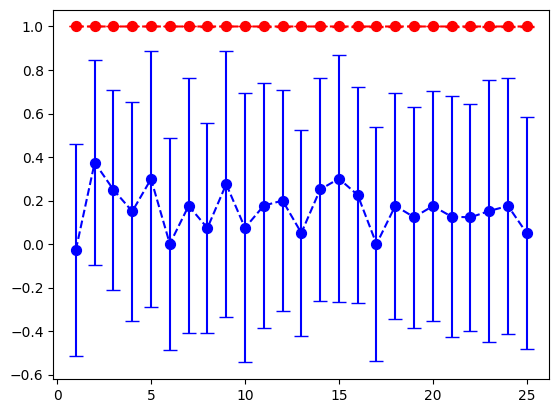

In [ ]:
plt.errorbar(nSweep, regular_RBAverage, yerr=regular_RBStd, linestyle='dashed', color='red', capsize=5)
plt.scatter(nSweep, regular_RBAverage, color='red', s=50)
plt.errorbar(nSweep, ZZ_RBAverage, yerr=ZZ_RBStd, linestyle='dashed', color='blue', capsize=5)
plt.scatter(nSweep, ZZ_RBAverage, color='blue', s=50)
plt.show()

In [ ]:
def rb(x, *p):
    return p[2] - p[0] * np.power(p[1], x)

pguess = [
    -0.5,
    0.999,
    0.5
]

regular_popt, regular_pcov = curve_fit(rb, nSweep, regular_RBAverage, p0=pguess)
regular_fit = rb(nSweep, *regular_popt)

regular_p = regular_popt[1]
regular_cliffErr = (1 - regular_p) * 0.5
regular_gateErr = regular_cliffErr / 1.875
regular_gateFidelty = 1 - regular_gateErr

print(f"Gate Fidelity: {int(regular_gateFidelty * 100000) / 1000}%")

Gate Fidelity: 100.0%


In [ ]:
def rb(x, *p):
    return p[2] - p[0] * np.power(p[1], x)

pguess = [
    -0.5,
    0.999,
    0.5
]

ZZ_popt, ZZ_pcov = curve_fit(rb, nSweep, ZZ_RBAverage, p0=pguess)
ZZ_fit = rb(nSweep, *ZZ_popt)

ZZ_p = ZZ_popt[1]
ZZ_cliffErr = (1 - ZZ_p) * 0.5
ZZ_gateErr = ZZ_cliffErr / 1.875
ZZ_gateFidelty = 1 - ZZ_gateErr

print(f"Gate Fidelity: {int(ZZ_gateFidelty * 100000) / 1000}%")

Gate Fidelity: 99.999%


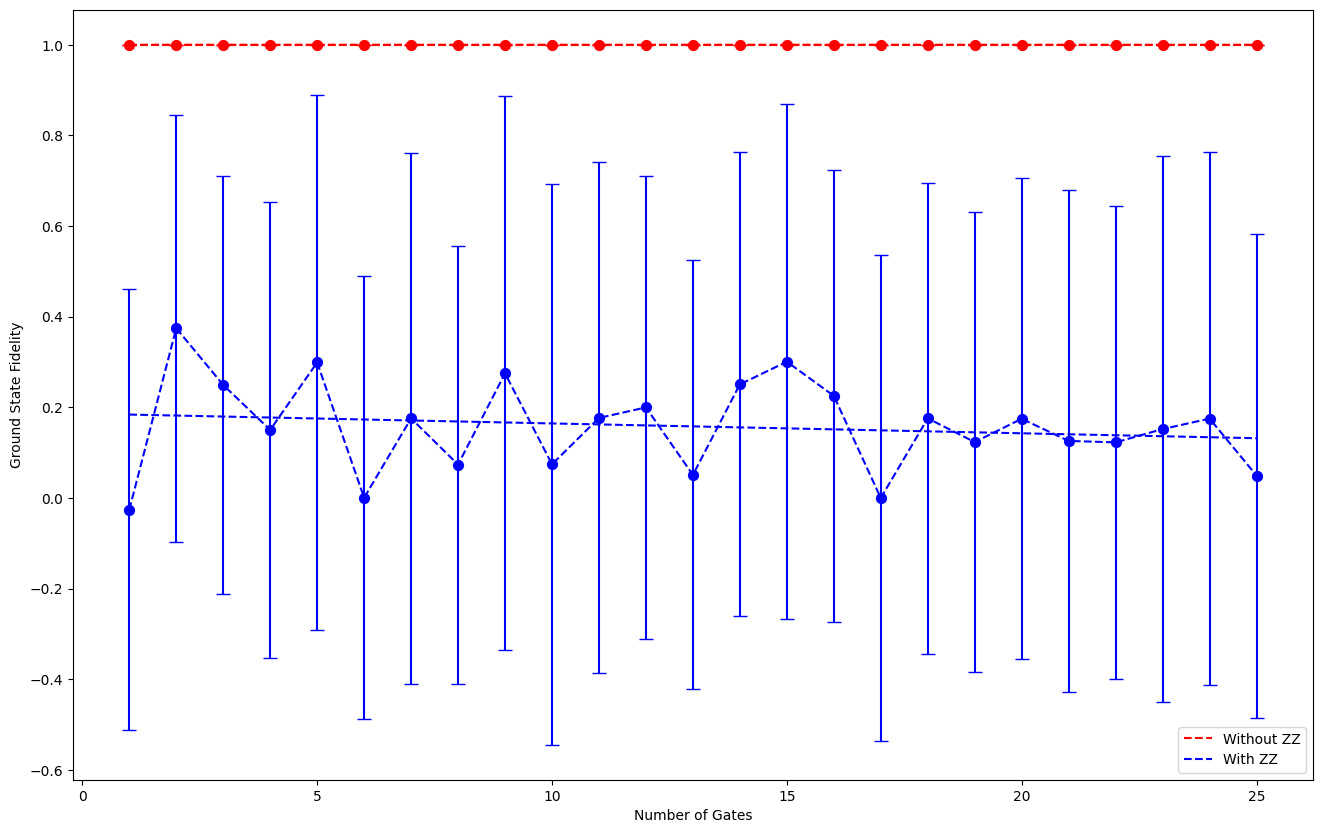

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(nSweep, regular_fit, color="red", linestyle='dashed', label='Without ZZ')
plt.errorbar(nSweep, regular_RBAverage, yerr=regular_RBStd, linestyle='dashed', color='red', capsize=5)
plt.scatter(nSweep, regular_RBAverage, color='red', s=50)
plt.xlabel("Number of Gates")
plt.ylabel("Ground State Fidelity")

plt.plot(nSweep, ZZ_fit, color="blue", linestyle='dashed', label='With ZZ')
plt.errorbar(nSweep, ZZ_RBAverage, yerr=ZZ_RBStd, linestyle='dashed', color='blue', capsize=5)
plt.scatter(nSweep, ZZ_RBAverage, color='blue', s=50)
plt.legend()
plt.savefig('myfig')
plt.show()

## References

<a name="cite_note-1"></a>1. [^](#cite_ref-1) A Quantum Engineer's Guide to Superconducting Qubits by Krantz P. et al

<a name="cite_note-2"></a>2. [^](#cite_ref-2) ICARUS-Q: Integrated control and readout unit for scalable quantum processors by Park K.H. et al